In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mplfinance as mpf

# 模拟数据部分（您的原始代码）
np.random.seed(42)
n = 1440
times = pd.date_range(start='2023-01-01', periods=n, freq='T')

start_price = 100.0
close_prices = np.cumsum(np.random.normal(0, 0.5, n)) + start_price
open_prices = np.roll(close_prices, 1)
open_prices[0] = start_price

high_prices = np.zeros(n)
low_prices = np.zeros(n)
for i in range(n):
    body_max = max(open_prices[i], close_prices[i])
    body_min = min(open_prices[i], close_prices[i])
    high_prices[i] = body_max + np.random.uniform(0, 0.5)
    low_prices[i] = body_min - np.random.uniform(0, 0.5)

volumes = np.random.randint(100, 500, n)

df = pd.DataFrame({
    'open': open_prices,
    'high': high_prices,
    'low': low_prices,
    'close': close_prices,
    'volume': volumes
}, index=times)



In [302]:
bw_xishu = 0.15

In [303]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.neighbors import KernelDensity



def generate_5s_ohlcv(ohlcv_1m):
    """
    修复版本：确保所有数组长度一致
    """
    # 生成时间索引（调整为12个5秒间隔）
    new_freq = '5S'
    ohlcv_5s = pd.DataFrame()
    
    for idx, row in ohlcv_1m.iterrows():
        # 生成13个价格点（0-60秒）
        price_path = generate_price_path_v2(
            row['open'], row['high'], row['low'], row['close']
        )
        
        # 生成12个成交量分配
        volume_dist = calculate_volume_distribution_v2(
            price_path, row['volume']
        )
        
        # 创建时间序列（12个时间戳：09:30:05 - 09:31:00）
        period_start = row['timestamp']
        timestamps = pd.date_range(
            start=period_start + pd.Timedelta(seconds=5),
            end=period_start + pd.Timedelta(minutes=1),
            freq=new_freq
        )
        
        # 计算OHLC（12个数据点）
        opens = price_path[:-1]
        closes = price_path[1:]
        highs = np.maximum.accumulate(closes)
        lows = np.minimum.accumulate(closes)
        
        period_data = pd.DataFrame({
            'timestamp': timestamps,
            'open': opens,
            'high': highs,
            'low': lows,
            'close': closes,
            'volume': volume_dist
        })
        
        ohlcv_5s = pd.concat([ohlcv_5s, period_data])
    print(f"生成数据量: {len(ohlcv_5s)} 行")
    return ohlcv_5s.reset_index(drop=True)

def generate_price_path_v2(open_p, high, low, close):
    """生成13个价格点（0-60秒）"""
    key_times = np.array([0, 30, 60])  # 0s, 30s, 60s
    key_prices = [open_p, np.nan, close]
    
    # 确定中间极值
    if high == max(open_p, close):
        key_prices[1] = high
    elif low == min(open_p, close):
        key_prices[1] = low
    else:
        key_prices[1] = (high + low)/2
    
    # 三次样条插值
    cs = CubicSpline(key_times, key_prices, bc_type='clamped')
    
    # 生成0-60秒的13个点（包含端点）
    time_points = np.arange(0, 61, 5)
    prices = cs(time_points)
    
    # 确保价格在原始范围内
    return np.clip(prices, low, high)

def calculate_volume_distribution_v2(prices, total_volume):
    """生成12个成交量分配"""
    # 使用滑动窗口计算波动率
    returns = np.abs(np.diff(prices)/prices[:-1])
    
    # 添加时间衰减因子（后期成交量减少）
    time_decay = np.linspace(1.0, 0.8, len(returns))
    weights = returns * time_decay
    
    # 归一化处理
    weights /= weights.sum()
    volumes = np.round(weights * total_volume).astype(int)
    
    # 处理余数
    remainder = total_volume - volumes.sum()
    if remainder > 0:
        volumes[-1] += remainder  # 将余数加到最后一根K线
    
    return volumes

# 测试数据
# data_1m = pd.DataFrame({
#     'timestamp': pd.date_range('2023-01-01 09:30', periods=3, freq='1min'),
#     'open': [1800.0, 1805.0, 1810.0],
#     'high': [1808.0, 1812.0, 1815.0],
#     'low': [1798.0, 1802.0, 1808.0],
#     'close': [1805.0, 1810.0, 1812.0],
#     'volume': [2500, 3200, 2800]
# })

# data_1m = df[:5]

# # 运行测试
# data_5s = generate_5s_ohlcv(data_1m)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import time

from chanlun import kcharts
from chanlun.cl_utils import query_cl_chart_config
from chanlun.exchange import get_exchange, Market
from chanlun.exchange.exchange_db import ExchangeDB
from chanlun import cl

import itertools
import talib
from chanlun.cl_utils import *
from chanlun.cl_interface import Config

# 市场
market = 'a'  # a 沪深A股  hk 港股 us 美股 futures 期货 currency 数字货币
# 标的代码
code = 'SHSE.000300'
# 获取周期，可设置多个
frequencys = ['1m']
# frequencys = ['30m','5m']
# 开始时间（需要api接口支持）
start_date = "2025-05-16 09:30:00"
# 结束时间（需要api接口支持）
end_date = "2025-05-16 15:01:00"
# 缠论计算配置
cl_config = query_cl_chart_config(market, code)
print(cl_config)
# ex = get_exchange(Market(market)) # 使用在线的k线数据接口
ex = ExchangeDB(market) # 读取数据库中的k线数据

klines = ex.klines(code, frequency=frequencys, start_date=start_date, end_date=end_date)
# 假设 klines 是一个已经定义的 DataFrame
df = klines[['date','open','high','low','close','volume']]

# 确保 'date' 列是 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 设置 'date' 列为索引
df.set_index('date', inplace=True)
df['timestamp'] = df.index

data_5s = generate_5s_ohlcv(df)

KeyboardInterrupt: 

In [305]:
df = data_5s
# 分箱处理（您的原始代码）
bin_size = 1
min_price = df['close'].min()
max_price = df['close'].max()
# # 加权计算average_price
# weights = {'open': 0.1, 'close': 0.4, 'high': 0.1, 'low': 0.1, 'open_close_avg': 0.2, 'all_avg': 0.1}
# df['open_close_avg'] = (df['open'] + df['close']) / 2
# df['all_avg'] = (df['open'] + df['close'] + df['high'] + df['low']) / 4
# use_close = True
# if use_close:
#     df['average_price'] = df['close']
# else:
#     df['average_price'] = (df['open'] * weights['open'] +
#                        df['close'] * weights['close'] +
#                        df['high'] * weights['high'] +
#                        df['low'] * weights['low'] +
#                        df['open_close_avg'] * weights['open_close_avg'] +
#                        df['all_avg'] * weights['all_avg'])




print(f"价格区间:({math.floor(min_price)},{math.ceil(max_price)}),波动幅度{math.ceil(max_price) - math.floor(min_price) }")
bins = np.arange(min_price - (min_price % bin_size), max_price + bin_size, bin_size)
print(len(bins))
print(len(df))
binned = pd.cut(df['close'], bins=bins)
volume_by_price = df.groupby(binned)['volume'].sum()
mid_points = [interval.mid for interval in volume_by_price.index]
volumes_sum = volume_by_price.values



价格区间:(3875,3904),波动幅度29
30
2868


In [306]:
# === 新增分析部分 ===
# 构建分析DataFrame
volume_df = pd.DataFrame({
    'price_bin': volume_by_price.index,
    'volume': volume_by_price.values,
    'mid_price': mid_points
})
volume_df['volume_ratio'] = volume_df['volume'] / volume_df['volume'].sum()
volume_df_sorted = volume_df.sort_values('mid_price').reset_index(drop=True)



# 1. 计算POC
poc_row = volume_df_sorted.loc[volume_df_sorted['volume'].idxmax()]
poc = poc_row['mid_price']

# === 输出关键指标 ===
print(f"POC: {poc:.2f}")


POC: 3888.50


In [307]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# KDE 平滑处理
price_points = np.array(mid_points)
volume_values = np.array(volumes_sum)

# 确保 KDE 使用正确的权重（归一化）
kde = gaussian_kde(dataset=price_points, weights=volume_values / volume_values.sum())

# 调整带宽（bandwidth）以获得更平滑或更敏感的密度函数
kde.set_bandwidth(bw_method=kde.factor * bw_xishu)  # 适当增大带宽

price_grid = np.linspace(price_points.min(), price_points.max(), 1000)
density = kde(price_grid)

# 检测极大值（带 prominence 返回）
peaks, props = find_peaks(density, prominence=0.001)

# 按 prominence 降序排序,取前4个
sorted_indices = np.argsort(props['prominences'])[::-1]
if len(peaks) >= 4:
   sorted_indices = sorted_indices[:4]
peak_prices = price_grid[peaks[sorted_indices]]

# 检测极小值（低谷）升序排序，取前3个
troughs, props = find_peaks(-density, prominence=0.001)
sorted_indices = np.argsort(props['prominences'])[::-1]
if len(troughs) >= 3:
    sorted_indices =sorted_indices[:3]
trough_prices = price_grid[troughs[sorted_indices]]

# # 筛选有效极小值点（位于两个极大值之间）
valid_troughs = []
for t in trough_prices:
    left_peak = max([p for p in peak_prices if p < t], default=None)
    right_peak = min([p for p in peak_prices if p > t], default=None)
    if left_peak is not None and right_peak is not None:
        valid_troughs.append(t)

# 添加价格上下边缘点作为极小值
min_price = price_points.min()
max_price = price_points.max()

# 判断是否已包含边缘点（允许一定误差）
edge_tol = 0.1  # 允许 0.1 的误差
if not any(abs(t - min_price) < edge_tol for t in trough_prices):
    trough_prices = np.append(trough_prices, min_price)
    valid_troughs.append(min_price)
if not any(abs(t - max_price) < edge_tol for t in trough_prices):
    trough_prices = np.append(trough_prices, max_price)
    valid_troughs.append(max_price)


# 重新排序
peak_prices = sorted(peak_prices)
valid_troughs = sorted(valid_troughs)
# 输出结果
print("密集区峰值位置（极大值）:")
for i, p in enumerate(peak_prices):
    print(f"  峰值 {i+1}: {p:.2f}")

print("\n连接密集区的极小值点（低谷）:")
for i, t in enumerate(valid_troughs):
    print(f"  低谷 {i+1}: {t:.2f}")

密集区峰值位置（极大值）:
  峰值 1: 3876.57
  峰值 2: 3882.96
  峰值 3: 3888.45
  峰值 4: 3899.44

连接密集区的极小值点（低谷）:
  低谷 1: 3875.50
  低谷 2: 3878.39
  低谷 3: 3886.18
  低谷 4: 3896.69
  低谷 5: 3903.50


In [308]:
#获取成交量稀疏区域

def get_closest_mid_price(trough_price, mid_points):
    """查找与 trough_price 最接近的 mid_price"""
    idx = np.argmin(np.abs(np.array(mid_points) - trough_price))
    return mid_points[idx]

def get_trough_region(trough_price, volume_df_sorted, total_volume,xishu=0.03):
    """生成成交量占比不超过 3% 的极小值区域"""
    # 查找最接近的 mid_price
    mid_points = volume_df_sorted['mid_price'].values
    closest_price = get_closest_mid_price(trough_price, mid_points)

    match = volume_df_sorted[volume_df_sorted['mid_price'] == closest_price]
    if match.empty:
        print(f"警告：未找到极小值点 {trough_price:.2f} 对应的 mid_price，跳过该区域")
        return None

    idx = match.index[0]
    start_idx = end_idx = idx
    cum_volume = volume_df_sorted.loc[idx, 'volume']
    cum_volume_ratio = cum_volume / total_volume

    # 如果当前 bin 成交量已 ≥3%，直接返回
    if cum_volume_ratio >= xishu:
        return None
        # return {
        #     'start': volume_df_sorted.loc[start_idx, 'mid_price'],
        #     'end': volume_df_sorted.loc[end_idx, 'mid_price'],
        #     'volume_ratio': cum_volume_ratio
        # }

    # 向上下扩展，每次预判扩展后是否超限
    while True:
        can_extend_up = end_idx < len(volume_df_sorted) - 1
        can_extend_down = start_idx > 0

        if not can_extend_up and not can_extend_down:
            break

        up_vol = volume_df_sorted.loc[end_idx + 1, 'volume'] if can_extend_up else float('inf')
        down_vol = volume_df_sorted.loc[start_idx - 1, 'volume'] if can_extend_down else float('inf')

        # 优先扩展成交量更小的方向
        if up_vol < down_vol:
            # 预判扩展后是否超限
            if (cum_volume + up_vol) / total_volume > xishu:
                break
            end_idx += 1
            cum_volume += up_vol
        else:
            if (cum_volume + down_vol) / total_volume > xishu:
                break
            start_idx -= 1
            cum_volume += down_vol

        cum_volume_ratio = cum_volume / total_volume

    # 最终返回有效区间
    start_price = volume_df_sorted.loc[start_idx, 'mid_price']
    end_price = volume_df_sorted.loc[end_idx, 'mid_price']

    return {
        'start': start_price - bin_size / 2 ,
        'end': end_price + bin_size / 2,
        'volume_ratio': cum_volume_ratio
    }


trough_regions = []
total_volume = volume_df_sorted['volume'].sum()

for t in valid_troughs:
    region = get_trough_region(t, volume_df_sorted, total_volume)
    if region:
        trough_regions.append(region)



print("\n极小值区域（成交量占比 ≤3%）:")
for i, region in enumerate(trough_regions):
    print(f"  区域 {i+1}: [{region['start']:.2f}, {region['end']:.2f}], 成交量占比: {region['volume_ratio'] * 100:.2f}%")


极小值区域（成交量占比 ≤3%）:
  区域 1: [3875.00, 3876.00], 成交量占比: 0.72%
  区域 2: [3877.00, 3879.00], 成交量占比: 1.94%
  区域 3: [3896.00, 3897.00], 成交量占比: 1.37%
  区域 4: [3901.00, 3904.00], 成交量占比: 2.87%


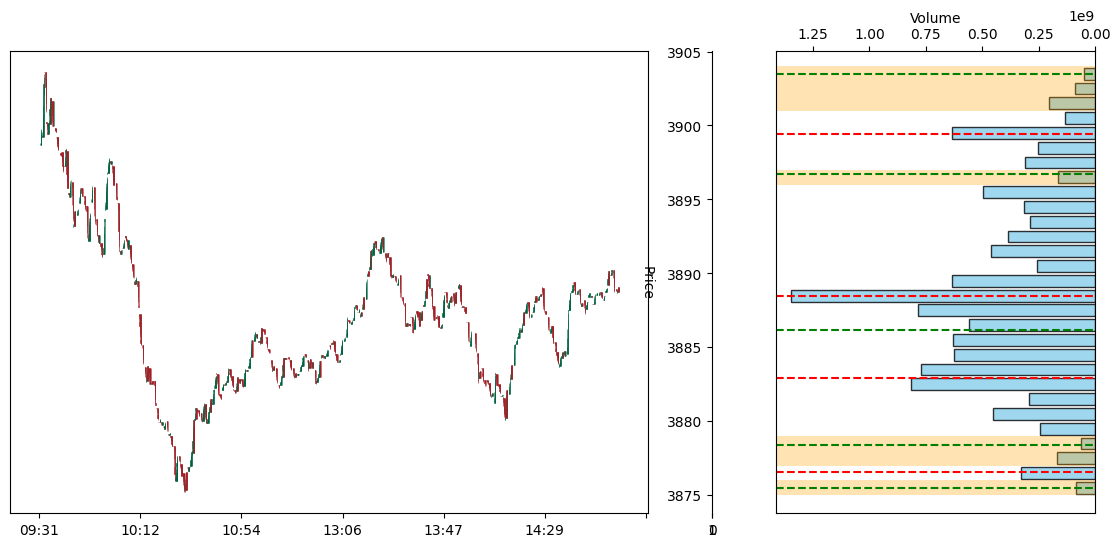

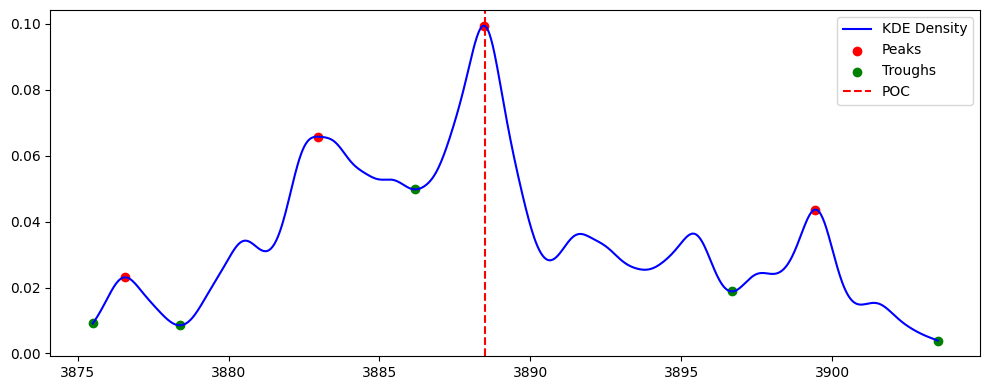

In [309]:
# 确保 'date' 列是 datetime 类型
df['date'] = pd.to_datetime(df['timestamp'])

# 设置 'date' 列为索引
df.set_index('date', inplace=True)

# === 可视化部分 ===
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 0, 1], figure=fig)

ax_k = fig.add_subplot(gs[0])
ax_center = fig.add_subplot(gs[1])
ax_vr = fig.add_subplot(gs[2])


# 绘制K线图
mpf.plot(df, type='candle', ax=ax_k, style='charles', show_nontrading=False, xrotation=0)

# 绘制VRVP图
ax_vr.barh(mid_points, volumes_sum, height=bin_size * 0.8,
           color='skyblue', edgecolor='black', alpha=0.8)
ax_vr.invert_xaxis()

# 设置共享Y轴
ylim = ax_k.get_ylim()
ax_vr.set_ylim(ylim)
ax_center.set_ylim(ylim)

# 可视化
ax_vr.plot(volume_values, price_points, color='skyblue', alpha=0)
for p in peak_prices:
    ax_vr.axhline(y=p, color='red', linestyle='--', linewidth=1.5)
for t in valid_troughs:
    ax_vr.axhline(y=t, color='green', linestyle='--', linewidth=1.5)


# 可视化 KDE 曲线和极值点
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(price_grid, density, label='KDE Density', color='blue')
ax.scatter(peak_prices, kde(peak_prices), color='red', label='Peaks')
ax.scatter(valid_troughs, kde(valid_troughs), color='green', label='Troughs')
ax.axvline(poc, color='red', linestyle='--', label='POC')
ax.legend()

# 标注极小值区域（阴影）
for region in trough_regions:
    ax_vr.axhspan(region['start'], region['end'], facecolor='orange', alpha=0.3)
    # # 同时标注极小值点
    # ax_vr.axhline(y=(region['start'] + region['end']) / 2, color='green', linestyle='--', linewidth=1.5)


# 配置中间轴
ax_center.yaxis.set_ticks_position('left')
ax_center.tick_params(axis='y', which='both', left=True, right=False)
ax_center.spines['top'].set_visible(False)
ax_center.spines['bottom'].set_visible(False)
ax_center.spines['left'].set_visible(True)
ax_center.spines['right'].set_visible(False)
ax_center.set_ylabel('Price', rotation=270, labelpad=20)

# 配置其他轴
ax_k.yaxis.set_visible(False)
ax_vr.yaxis.set_visible(False)
ax_vr.set_xlabel('Volume')
ax_vr.xaxis.set_label_position('top')
ax_vr.xaxis.tick_top()


# 自动调整布局
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()


                                          timestamp      open      high  \
date                                                                      
2025-05-16 09:31:05+08:00 2025-05-16 09:31:05+08:00  3898.666  3898.666   
2025-05-16 09:31:10+08:00 2025-05-16 09:31:10+08:00  3898.666  3898.666   
2025-05-16 09:31:15+08:00 2025-05-16 09:31:15+08:00  3898.666  3898.666   
2025-05-16 09:31:20+08:00 2025-05-16 09:31:20+08:00  3898.666  3898.666   
2025-05-16 09:31:25+08:00 2025-05-16 09:31:25+08:00  3898.666  3898.666   

                                low     close  volume  
date                                                   
2025-05-16 09:31:05+08:00  3898.666  3898.666       0  
2025-05-16 09:31:10+08:00  3898.666  3898.666       0  
2025-05-16 09:31:15+08:00  3898.666  3898.666       0  
2025-05-16 09:31:20+08:00  3898.666  3898.666       0  
2025-05-16 09:31:25+08:00  3898.666  3898.666       0  
                                          timestamp      open      high  \
date   

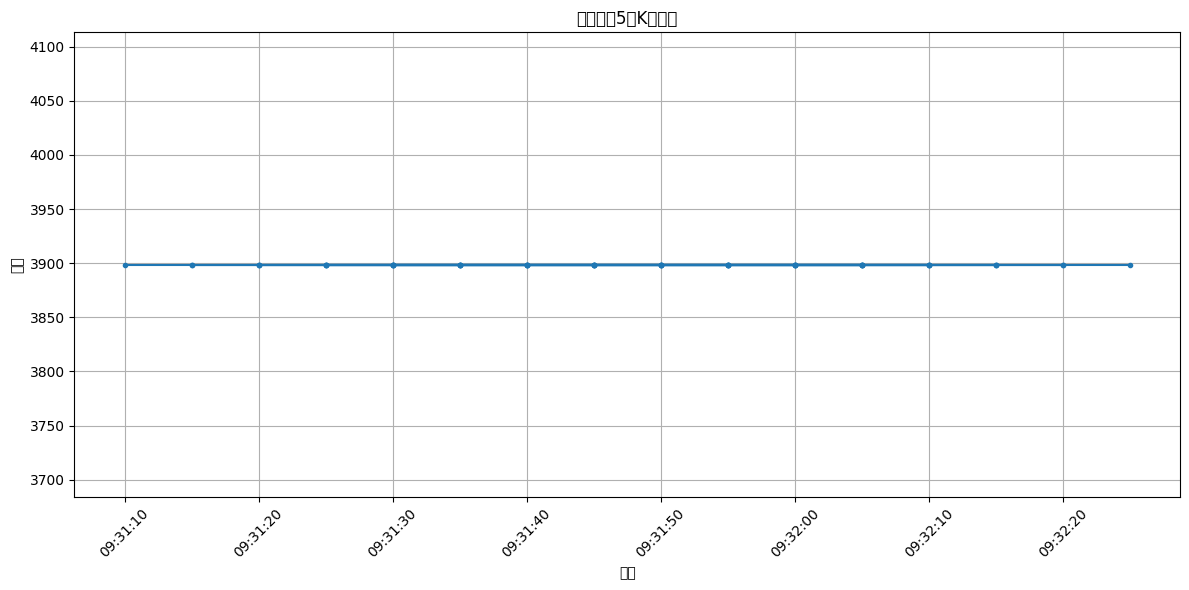

In [310]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.neighbors import KernelDensity

def generate_5s_ohlcv(ohlcv_1m):
    """
    修复版本：确保所有数组长度一致
    """
    # 生成时间索引（调整为12个5秒间隔）
    new_freq = '5S'
    ohlcv_5s = pd.DataFrame()
    
    for idx, row in ohlcv_1m.iterrows():
        # 生成13个价格点（0-60秒）
        price_path = generate_price_path_v2(
            row['open'], row['high'], row['low'], row['close']
        )
        
        # 生成12个成交量分配
        volume_dist = calculate_volume_distribution_v2(
            price_path, row['volume']
        )
        
        # 创建时间序列（12个时间戳：09:30:05 - 09:31:00）
        period_start = row['timestamp']
        timestamps = pd.date_range(
            start=period_start + pd.Timedelta(seconds=5),
            end=period_start + pd.Timedelta(minutes=1),
            freq=new_freq
        )
        
        # 计算OHLC（12个数据点）
        opens = price_path[:-1]
        closes = price_path[1:]
        highs = np.maximum.accumulate(closes)
        lows = np.minimum.accumulate(closes)
        
        period_data = pd.DataFrame({
            'timestamp': timestamps,
            'open': opens,
            'high': highs,
            'low': lows,
            'close': closes,
            'volume': volume_dist
        })
        
        ohlcv_5s = pd.concat([ohlcv_5s, period_data])
    
    return ohlcv_5s.reset_index(drop=True)

def generate_price_path_v2(open_p, high, low, close):
    """生成13个价格点（0-60秒）"""
    key_times = np.array([0, 30, 60])  # 0s, 30s, 60s
    key_prices = [open_p, np.nan, close]
    
    # 确定中间极值
    if high == max(open_p, close):
        key_prices[1] = high
    elif low == min(open_p, close):
        key_prices[1] = low
    else:
        key_prices[1] = (high + low)/2
    
    # 三次样条插值
    cs = CubicSpline(key_times, key_prices, bc_type='clamped')
    
    # 生成0-60秒的13个点（包含端点）
    time_points = np.arange(0, 61, 5)
    prices = cs(time_points)
    
    # 确保价格在原始范围内
    return np.clip(prices, low, high)

def calculate_volume_distribution_v2(prices, total_volume):
    """生成12个成交量分配"""
    # 使用滑动窗口计算波动率
    returns = np.abs(np.diff(prices)/prices[:-1])
    
    # 添加时间衰减因子（后期成交量减少）
    time_decay = np.linspace(1.0, 0.8, len(returns))
    weights = returns * time_decay
    
    # 归一化处理
    weights /= weights.sum()
    volumes = np.round(weights * total_volume).astype(int)
    
    # 处理余数
    remainder = total_volume - volumes.sum()
    if remainder > 0:
        volumes[-1] += remainder  # 将余数加到最后一根K线
    
    return volumes

# 测试数据
# data_1m = pd.DataFrame({
#     'timestamp': pd.date_range('2023-01-01 09:30', periods=3, freq='1min'),
#     'open': [1800.0, 1805.0, 1810.0],
#     'high': [1808.0, 1812.0, 1815.0],
#     'low': [1798.0, 1802.0, 1808.0],
#     'close': [1805.0, 1810.0, 1812.0],
#     'volume': [2500, 3200, 2800]
# })
print(df.head(5))
data_1m = df[:5]
print(data_1m.head(1))
# 运行测试
data_5s = generate_5s_ohlcv(data_1m)
print(f"生成数据量: {len(data_5s)} 行")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data_5s['timestamp'], data_5s['close'], marker='o', markersize=3)
plt.title('修正后的5秒K线数据')
plt.xlabel('时间')
plt.ylabel('价格')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [311]:
data_5s

,timestamp,open,high,low,close,volume
0,2025-05-16 09:31:10+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
1,2025-05-16 09:31:15+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
2,2025-05-16 09:31:20+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
3,2025-05-16 09:31:25+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
4,2025-05-16 09:31:30+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
5,2025-05-16 09:31:35+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
6,2025-05-16 09:31:40+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
7,2025-05-16 09:31:45+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
8,2025-05-16 09:31:50+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648
9,2025-05-16 09:31:55+08:00,3898.666,3898.666,3898.666,3898.666,-2147483648


In [312]:
type(df['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [313]:
data_1m = pd.DataFrame({
    'timestamp': pd.date_range('2023-01-01 09:30', periods=3, freq='1min'),
    'open': [1800.0, 1805.0, 1810.0],
    'high': [1808.0, 1812.0, 1815.0],
    'low': [1798.0, 1802.0, 1808.0],
    'close': [1805.0, 1810.0, 1812.0],
    'volume': [2500, 3200, 2800]
})

In [314]:
type(data_1m['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [315]:
type(df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [316]:
df

,timestamp,open,high,low,close,volume
date,,,,,,
2025-05-16 09:31:05+08:00,2025-05-16 09:31:05+08:00,3898.666,3898.666,3898.666000,3898.666,0
2025-05-16 09:31:10+08:00,2025-05-16 09:31:10+08:00,3898.666,3898.666,3898.666000,3898.666,0
2025-05-16 09:31:15+08:00,2025-05-16 09:31:15+08:00,3898.666,3898.666,3898.666000,3898.666,0
2025-05-16 09:31:20+08:00,2025-05-16 09:31:20+08:00,3898.666,3898.666,3898.666000,3898.666,0
2025-05-16 09:31:25+08:00,2025-05-16 09:31:25+08:00,3898.666,3898.666,3898.666000,3898.666,0
...,...,...,...,...,...,...
2025-05-16 15:00:40+08:00,2025-05-16 15:00:40+08:00,3889.085,3889.085,3888.721834,3889.085,0
2025-05-16 15:00:45+08:00,2025-05-16 15:00:45+08:00,3889.085,3889.085,3888.721834,3889.085,0
2025-05-16 15:00:50+08:00,2025-05-16 15:00:50+08:00,3889.085,3889.085,3888.721834,3889.085,0
